In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from aligners.helpers import load_reference_genome
import random

In [3]:
fasta_file = "/mnt/SSD2/pholur/General_Models/data/thermus_aquaticus/thermus_aquaticus.fasta"
dictionary_of_reference = load_reference_genome(fasta_file)

In [4]:
dictionary_of_reference.keys()

dict_keys(['NZ_CP010822.1', 'NZ_CP010823.1', 'NZ_CP010824.1', 'NZ_CP010825.1', 'NZ_CP010826.1'])

In [5]:
for k,v in dictionary_of_reference.items():
    print(k, len(v))

NZ_CP010822.1 2158963
NZ_CP010823.1 14448
NZ_CP010824.1 16597
NZ_CP010825.1 69906
NZ_CP010826.1 78727


In [6]:
subsequence_of_reference = dictionary_of_reference["NZ_CP010822.1"]

In [7]:
print(subsequence_of_reference[:500 ])

GTGGCCTTGACGCACGAGGCGGTCTGGCAGCACGTTCTGGAGCACATCCGCCGCAACATCACCGAGGTGGAGTACCACACCTGGTTTGAAAGGATCCGCCCCCTGGGTATCCGGGAAGGGGTTTTGGAGCTGGCGGTGCCCACCTCCTTCGCCCTGGACTGGATCAAGCGGCACTACGCCCCCCTGATCCAGGAGGCTTTAGGCCTCCTGGGGGCCCAGGTACCCCGCTTTGAGCTTTTGGTGGTGCCCGGAGCCGCCCAGCCGGTCCAGGTGGACATCTTCCAGGCCGTCCCCCAGGCCGACCAGGGGAAGTCCAAGCTCAACCCCAAGTACACCTTTGAGAACTTCGTGGTGGGGCCCAACAACAACCTGGCCCACGCCGCGGCCGTGGCCGTGGCCGAGTCGCCCGGCAAGGCCTACAACCCCCTTTTCATCTACGGGGGGGTGGGCCTGGGCAAGACCCACCTCATGCACGCCGTGGGCCACTCGGTAGCCAAGCG


In [8]:
def swap_characters(input_string):
    # Calculate the number of characters to swap (10% of the string length)
    num_chars_to_swap = int(len(input_string) * 0.01)

    # Convert string to a list to allow character swapping
    chars = list(input_string)

    # Perform swaps
    for _ in range(num_chars_to_swap):
        # Randomly select two distinct indices within the string length
        index1, index2 = random.sample(range(len(chars)), 2)

        # Swap the characters at the selected indices
        chars[index1], chars[index2] = chars[index2], chars[index1]

    # Convert the list back to a string
    modified_string = ''.join(chars)
    return modified_string

In [9]:
def get_subsequences(sequence, sample_length, overlap, mode="raw"):
    start = 0
    sample_count = 0
    subsequences = []
    if mode == "raw":
        while start < len(sequence): # NASA-esque hard upper limit
            subsequences.append([
                sequence[start:min(start + sample_length, len(sequence))].upper(),
                str(sample_count)
                ]
            )
            start += sample_length
            if overlap != None and overlap < sample_length:
                start -= overlap
            sample_count += 1

    elif mode == "simulated":
        while start < len(sequence): # NASA-esque hard upper limit
            # Calculate the random sample length with mean at sample_length and range of sample_length ± 200
            random_sample_length = min(max(int(random.uniform(sample_length - 200, sample_length + 200)), 1), len(sequence) - start)
            subsequences.append([
                sequence[start:min(start + random_sample_length, len(sequence))].upper(),
                str(sample_count)
            ])

            if (start + random_sample_length) >= len(sequence):
                break

            overlap_fine = int(random.uniform(overlap - 100, overlap + 100))
            start += random_sample_length - overlap_fine
            sample_count += 1

    elif mode == "simulated_with_noise":
        while start < len(sequence): # NASA-esque hard upper limit
            # Calculate the random sample length with mean at sample_length and range of sample_length ± 200
            random_sample_length = min(max(int(random.uniform(sample_length - 200, sample_length + 200)), 1), len(sequence) - start)
            parter = sequence[start:min(start + random_sample_length, len(sequence))].upper()

            subsequences.append([
                swap_characters(parter),
                str(sample_count)
            ])

            if (start + random_sample_length) >= len(sequence):
                break

            start += random_sample_length - int(random.uniform(overlap - 100, overlap + 100))
            sample_count += 1

    return subsequences

In [10]:
splices = get_subsequences(subsequence_of_reference, 1000, 800, mode="simulated") # vs. simulated

In [11]:
# PATH fix to locate dna2vec package
import os, sys
sys.path.append(os.getcwd() + "/../src")

In [12]:
from inference_models import EvalModel
import torch
import yaml

with open("configs/model_checkpoints.yaml", 'r') as stream:
    checkpoints = yaml.safe_load(stream)

from dna2vec.model import model_from_config

def _load_model_for_inference(alias, device="cuda:3"):
    received = torch.load(checkpoints[alias], map_location="cpu")
    config = received["config"]
    config.model_config.tokenizer_path = checkpoints["tokenizer"]
    encoder, pooling, tokenizer = model_from_config(config.model_config)
    encoder.load_state_dict(received["model"])
    encoder.eval()
    model_params = {
                                "tokenizer": tokenizer,
                                "model": encoder,
                                "pooling": pooling,
                    }
    eval_model = EvalModel(
                model_params["tokenizer"],
                model_params["model"],
                model_params["pooling"],
                device = device
    )
    return eval_model

/mnt/SSD5/jshiffer/miniconda3/envs/dna2vec/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
print(len(splices))

10848


In [14]:
from tqdm import tqdm
eval_model = _load_model_for_inference("trained-all-longer")

/mnt/SSD5/jshiffer/miniconda3/envs/dna2vec/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [15]:
representations = []
labels = []
for splice in tqdm(splices):
    representations.append(eval_model.encode([splice[0]]))
    labels.append(splice[1])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10848/10848 [00:55<00:00, 194.67it/s]


In [16]:
import numpy as np
representations_np = np.array(representations)

In [17]:
representations_np.shape

(10848, 384)

In [18]:
cutset = np.vstack(
    (representations_np[:100],
     representations_np[100:200],
     representations_np[200:300]))

In [19]:
import umap
model = umap.UMAP(n_components=2, n_neighbors=10)
vectors = model.fit_transform(cutset)

In [20]:
vectors.shape

(300, 2)

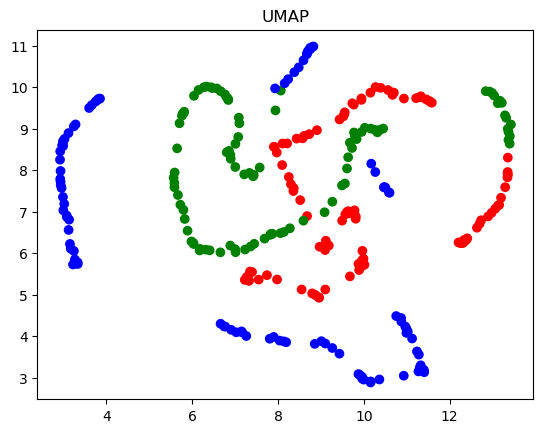

In [21]:
import matplotlib.pyplot as plt
plt.scatter(vectors[:,0], vectors[:,1], color=["red"]*100 + ["green"]*100 + ["blue"]*100)#, labels=labels)
plt.title('UMAP');

In [22]:
cutset = np.vstack(
    (representations_np[:100],
     representations_np[10000:10100],
     representations_np[5000:5100]))

In [23]:
import umap
model = umap.UMAP(n_components=2, n_neighbors=10)
vectors = model.fit_transform(cutset)

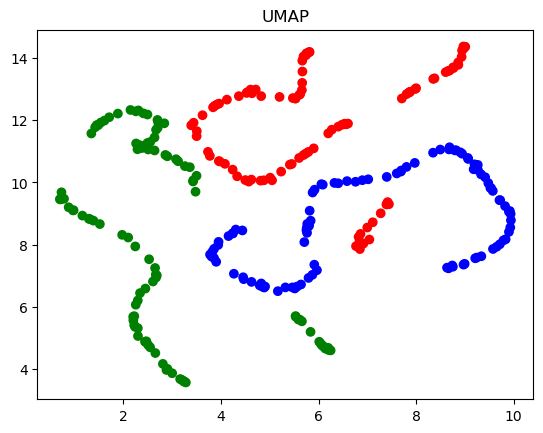

In [24]:
import matplotlib.pyplot as plt
plt.scatter(vectors[:,0], vectors[:,1], color=["red"]*100 + ["green"]*100 + ["blue"]*100)#, labels=labels)
plt.title('UMAP');

## Original space kNN graph processing

In [25]:
neighbor_graph = model.graph_

In [26]:
neighbor_graph

<300x300 sparse matrix of type '<class 'numpy.float32'>'
	with 3362 stored elements in Compressed Sparse Row format>

In [27]:
neighbor_graph = neighbor_graph.todense()

In [28]:
neighbor_graph

matrix([[0.        , 1.        , 0.9169167 , ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.        , 0.69290805, ..., 0.        , 0.        ,
         0.        ],
        [0.9169167 , 0.69290805, 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
         0.80127835],
        [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
         1.        ],
        [0.        , 0.        , 0.        , ..., 0.80127835, 1.        ,
         0.        ]], dtype=float32)

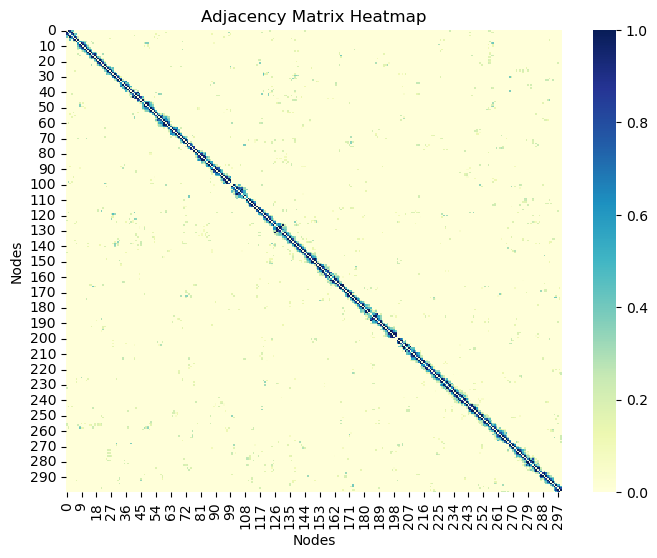

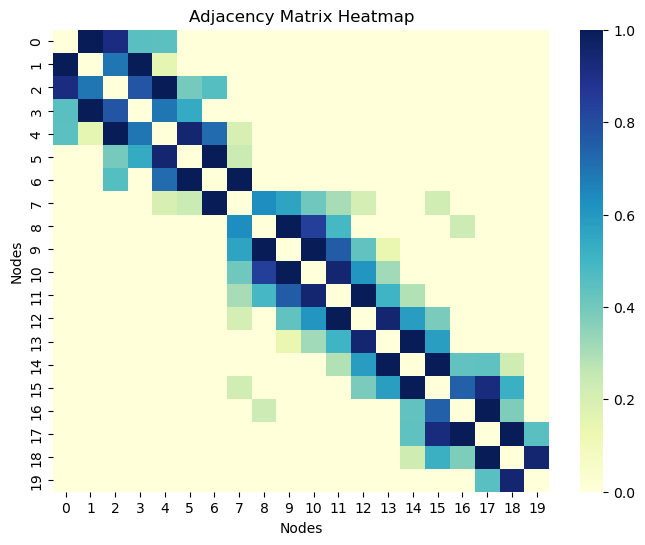

In [29]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(neighbor_graph, cmap='YlGnBu', fmt='d')
plt.title('Adjacency Matrix Heatmap')
plt.xlabel('Nodes')
plt.ylabel('Nodes')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(neighbor_graph[:20,:20], cmap='YlGnBu', fmt='d')
plt.title('Adjacency Matrix Heatmap')
plt.xlabel('Nodes')
plt.ylabel('Nodes')
plt.show()

## Transform it into a TSP for NetworkX support
TSP has approximate and more-optimized kernels than finding the hamilton path, that instead appears to time-out under some specific constraints.

In [57]:
import networkx as nx
neighbor_graph[-1,0] = 1 # ensure easy return

In [58]:
G = nx.Graph((1 - neighbor_graph) + 0.1)

Text(0, 0.5, 'Fragment')

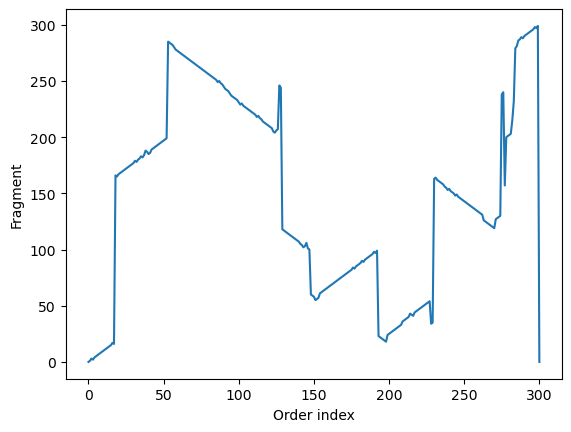

In [59]:
hamiltonian_path = nx.approximation.greedy_tsp(G)
plt.plot(range(len(hamiltonian_path)), hamiltonian_path)
plt.xlabel("Order index")
plt.ylabel("Fragment")

Text(0, 0.5, 'Fragment')

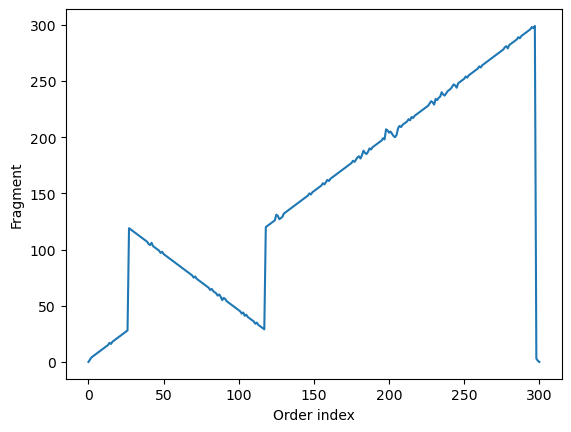

In [60]:
hamiltonian_path = nx.approximation.christofides(G)
plt.plot(range(len(hamiltonian_path)), hamiltonian_path)
plt.xlabel("Order index")
plt.ylabel("Fragment")

In [61]:
cutset = np.vstack(
    (representations_np[:100],
     representations_np[100:200],
     representations_np[200:300]))

import umap
model = umap.UMAP(n_components=2, n_neighbors=10)
vectors = model.fit_transform(cutset)

In [62]:
neighbor_graph = model.graph_.todense()

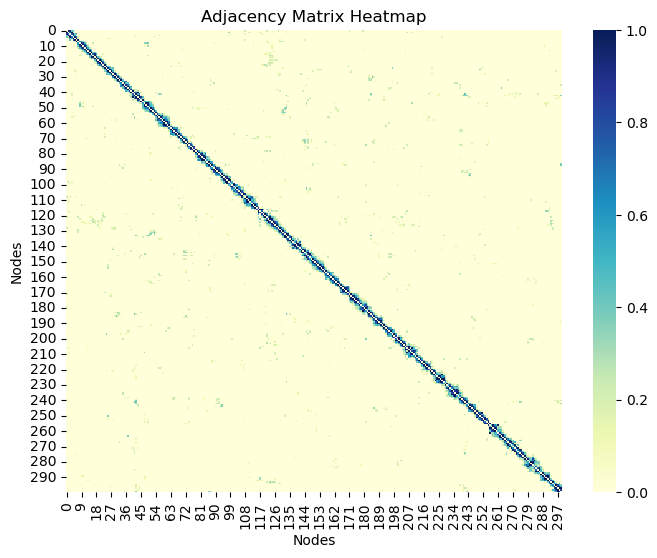

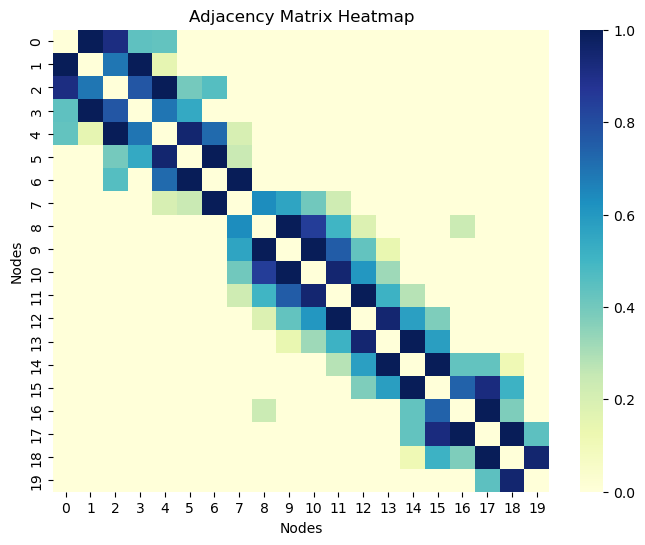

In [63]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(neighbor_graph, cmap='YlGnBu', fmt='d')
plt.title('Adjacency Matrix Heatmap')
plt.xlabel('Nodes')
plt.ylabel('Nodes')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(neighbor_graph[:20,:20], cmap='YlGnBu', fmt='d')
plt.title('Adjacency Matrix Heatmap')
plt.xlabel('Nodes')
plt.ylabel('Nodes')
plt.show()

Text(0, 0.5, 'Fragment')

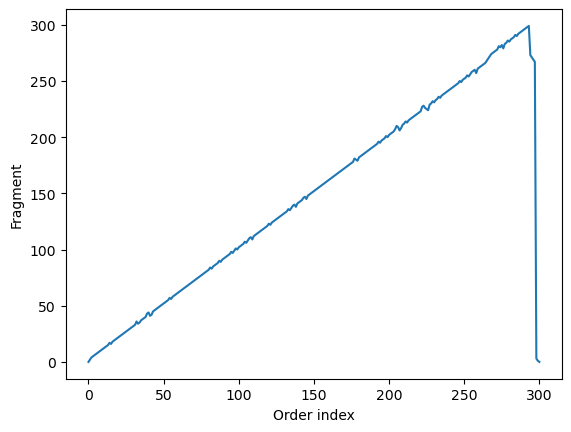

In [64]:
import networkx as nx
# neighbor_graph[-1,0] = 1 # ensure easy return
G = nx.Graph((1 - neighbor_graph) + 0.1)
hamiltonian_path = nx.approximation.christofides(G)
plt.plot(range(len(hamiltonian_path)), hamiltonian_path)
plt.xlabel("Order index")
plt.ylabel("Fragment")

## Beam Search

Applying the beam search algorithm on genome assembly by beam searching through the 4 nearest neighbors from the adjacency matrix.

In [30]:
import heapq
neighbors = neighbor_graph.tolist()

In [31]:
neighbors[0][:5]

[0.0, 1.0, 0.9169167280197144, 0.4523276686668396, 0.4437660574913025]

In [32]:
neighbors[1][:5]

[1.0, 0.0, 0.6929080486297607, 1.0, 0.1524796485900879]

In [81]:
# Change default value of "b" below to change branching factor

def KNN(i, b = 4):
    """
    Returns the indices & probabilities of the K nearest neighbors to the read of index `i`. 
    """
    # lookup table of indices by value
    rowdict = {}
    for j,k in enumerate(neighbors[i]):
        rowdict[k] = j
    n_largest = heapq.nlargest(b, neighbors[i])
    n_largest_i = [rowdict[l] for l in n_largest]
    return list(zip(n_largest_i, n_largest))

In [82]:
path = []
probs = []
row_i = 0
goal_i = neighbor_graph.shape[0] - 1
while row_i != goal_i:
    print("Finding neighbors of read", row_i)
    results = KNN(row_i)
    best_i, best_prob = results[0]
    if best_i == goal_i:
        path.append(best_i)
        probs.append(best_prob)
        print(path)
        print("reached the end")
        break

    # beam search depth of 3; for each neighbor, examine its 4 best neighbors
    # also avoid cycles
    max_neighbor = None
    max_prob = None
    max_joint_prob = 0.0
    for test_i, test_prob in results:
        if test_i in path:
            continue
        for test_i2, test_prob2 in KNN(test_i):
            if test_i2 in path:
                continue
            for test_i3, test_prob3 in KNN(test_i2):
                if test_i3 in path:
                    continue
                joint_prob = test_prob * test_prob2 * test_prob3
                if joint_prob > max_joint_prob:
                    max_neighbor = test_i
                    max_prob = test_prob
                    max_joint_prob = joint_prob
                    # advance by one layer
                    row_i = test_i
    
    if max_neighbor:
        path.append(max_neighbor)
        probs.append(max_prob)
        print(list(zip(path, probs)))
    else:
        print(list(zip(path, probs)))
        print("ran out of paths")
        break
            
print("done")

Finding neighbors of read 0
[(1, 1.0)]
Finding neighbors of read 1
[(1, 1.0), (3, 1.0)]
Finding neighbors of read 3
[(1, 1.0), (3, 1.0), (2, 0.7748700380325317)]
Finding neighbors of read 2
[(1, 1.0), (3, 1.0), (2, 0.7748700380325317), (4, 1.0)]
Finding neighbors of read 4
[(1, 1.0), (3, 1.0), (2, 0.7748700380325317), (4, 1.0), (5, 0.9493129253387451)]
Finding neighbors of read 5
[(1, 1.0), (3, 1.0), (2, 0.7748700380325317), (4, 1.0), (5, 0.9493129253387451), (6, 1.0)]
Finding neighbors of read 6
[(1, 1.0), (3, 1.0), (2, 0.7748700380325317), (4, 1.0), (5, 0.9493129253387451), (6, 1.0), (7, 1.0)]
Finding neighbors of read 7
[(1, 1.0), (3, 1.0), (2, 0.7748700380325317), (4, 1.0), (5, 0.9493129253387451), (6, 1.0), (7, 1.0), (8, 0.6312118768692017)]
Finding neighbors of read 8
[(1, 1.0), (3, 1.0), (2, 0.7748700380325317), (4, 1.0), (5, 0.9493129253387451), (6, 1.0), (7, 1.0), (8, 0.6312118768692017), (9, 1.0)]
Finding neighbors of read 9
[(1, 1.0), (3, 1.0), (2, 0.7748700380325317), (4, 1

Text(0, 0.5, 'Fragment')

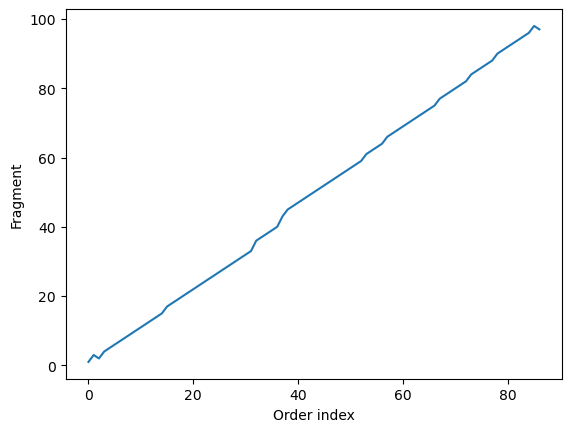

In [83]:
plt.plot(range(len(path)), path)
plt.xlabel("Order index")
plt.ylabel("Fragment")

Observations:
* With too low a depth (n<3), the beam search produces a massive skip around index 100 to fragment 300. A couple other significant jumps are also present
* At higher depths, the skip returns with too high a branching factor (b>7)
* At the "sweet spot", the line is fairly smooth, the noise is a bit higher in magnitude but far fewer occurrences than the Christofides algorithm